## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Ali Eghbali, Oriyomi Raheem, Michael Pyrcz, Carlos Torres-Verdin
***
## PINN-based Inversion (PyTorch)
***

In [1]:
from main import *

check_torch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
case1, case2, synthetic1, synthetic2 = load_all_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.2+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------

Name              : Source                : Shape
----------------- : --------------------- : -----------
Field Case 1      : (Chevron)             : (2399, 12)
Field Case 2      : (AkerBP)              : (11143, 12)
Synthetic Case 1  : (Laminated)           : (801, 14)
Synthetic Case 2  : (Laminated+Dispersed) : (415, 10)


***
### Physics-informed neural network inversion

In [2]:
class ResInvLoss(nn.Module):
    def __init__(self, dd_flag:bool=True, ddmax=100, lambda_reg=1e-5, lambda_p=2):
        super(ResInvLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.lambda_p   = lambda_p
        self.dd_flag    = dd_flag
        self.ddmax      = ddmax

    def forward(self, inputs, outputs):
        Rv_true = inputs[:, 0]
        Rh_true = inputs[:, 1]
        dd_true = inputs[:, 2]/self.ddmax
        Rvsh    = inputs[:, 3]
        Rhsh    = inputs[:, 4]

        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        eq1 = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        if self.dd_flag:
            wd1, wd2 = 1/Rv_true/dd_true, 1*Rh_true/dd_true
        else:
            wd1, wd2 = 1/Rv_true, 1*Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg*torch.norm(outputs, p=self.lambda_p)

        return  costf + regPa

In [3]:
class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.5):
        super(ResInvPINN, self).__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult*torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]

        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

In [4]:
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh', 'Rvsh', 'Rhsh']

zstart = int(np.argwhere(case1.index==9720).squeeze())
zend   = int(np.argwhere(case1.index==10110).squeeze())
data1  = case1.iloc[zstart:zend]

zstart = int(np.argwhere(case2.index==6292.75).squeeze())
zend   = int(np.argwhere(case2.index==9078.25).squeeze())
data2  = case2.iloc[zstart:zend]

data3 = synthetic1.dropna()
data4 = synthetic2.dropna()

data_all = pd.concat([data1, data2, data3, data4], ignore_index=False)
data_all

,CAL,AT10,AT30,AT60,AT90,GR,Rv,Rh,Rvsh,Rhsh,WNAME,WIDX,DPHI,NPHI,PEF,RHOZ,NPOR,PEFZ
DEPTH,,,,,,,,,,,,,,,,,,
9720.000000,12.8824,1.5269,1.1963,1.1103,1.1101,86.389800,3.809700,0.860700,2.813,0.775,Chevron,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9720.250000,12.8969,1.5301,1.2093,1.1268,1.1215,87.615800,3.887700,0.878300,2.813,0.775,Chevron,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9720.500000,12.9115,1.5334,1.2223,1.1433,1.1328,88.841800,3.952100,0.892100,2.813,0.775,Chevron,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9720.750000,12.8370,1.5219,1.2123,1.1382,1.1203,90.098200,3.998500,0.901700,2.813,0.775,Chevron,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9721.000000,12.7624,1.5104,1.2023,1.1331,1.1078,91.354600,4.027400,0.907600,2.813,0.775,Chevron,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193.841864,NaN,NaN,NaN,NaN,NaN,87.878399,8.440692,1.502505,10.000,1.000,Synthetic2,4.0,NaN,NaN,NaN,2.583608,0.215582,5.775533
5194.091864,NaN,NaN,NaN,NaN,NaN,87.649346,8.440692,1.502505,10.000,1.000,Synthetic2,4.0,NaN,NaN,NaN,2.594615,0.191394,5.764858
5194.341864,NaN,NaN,NaN,NaN,NaN,85.603797,8.440692,1.502505,10.000,1.000,Synthetic2,4.0,NaN,NaN,NaN,2.594937,0.153762,5.625162


***
## Chevron 2009

Inputs: torch.Size([1560, 6])
X_train: 1127 | X_valid: 199 | X_test: 234
# of Parameters: 23,402
Epoch: 0 | Loss: 1199.3149 | Valid Loss: 1453.7884
Epoch: 100 | Loss: 189.6582 | Valid Loss: 491.5352
Epoch: 200 | Loss: 131.7194 | Valid Loss: 171.4332
Epoch: 300 | Loss: 65.8222 | Valid Loss: 45.9388
Epoch: 400 | Loss: 53.5703 | Valid Loss: 51.4591
Epoch: 500 | Loss: 49.3882 | Valid Loss: 61.7497


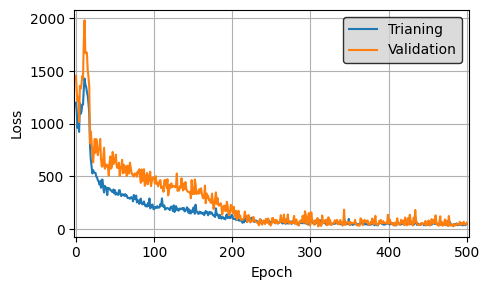

Csh: min=0.036 | max=0.681
Mean Squared Error - Rv: 0.1186  | Rh: 0.0459
R2 Score           - Rv: 99.705  | Rh: 93.772
Standard Error     - Rv: 0.5855  | Rh: 1.0291
Percentage Error   - Rv: 4.6076% | Rh: 14.0623%


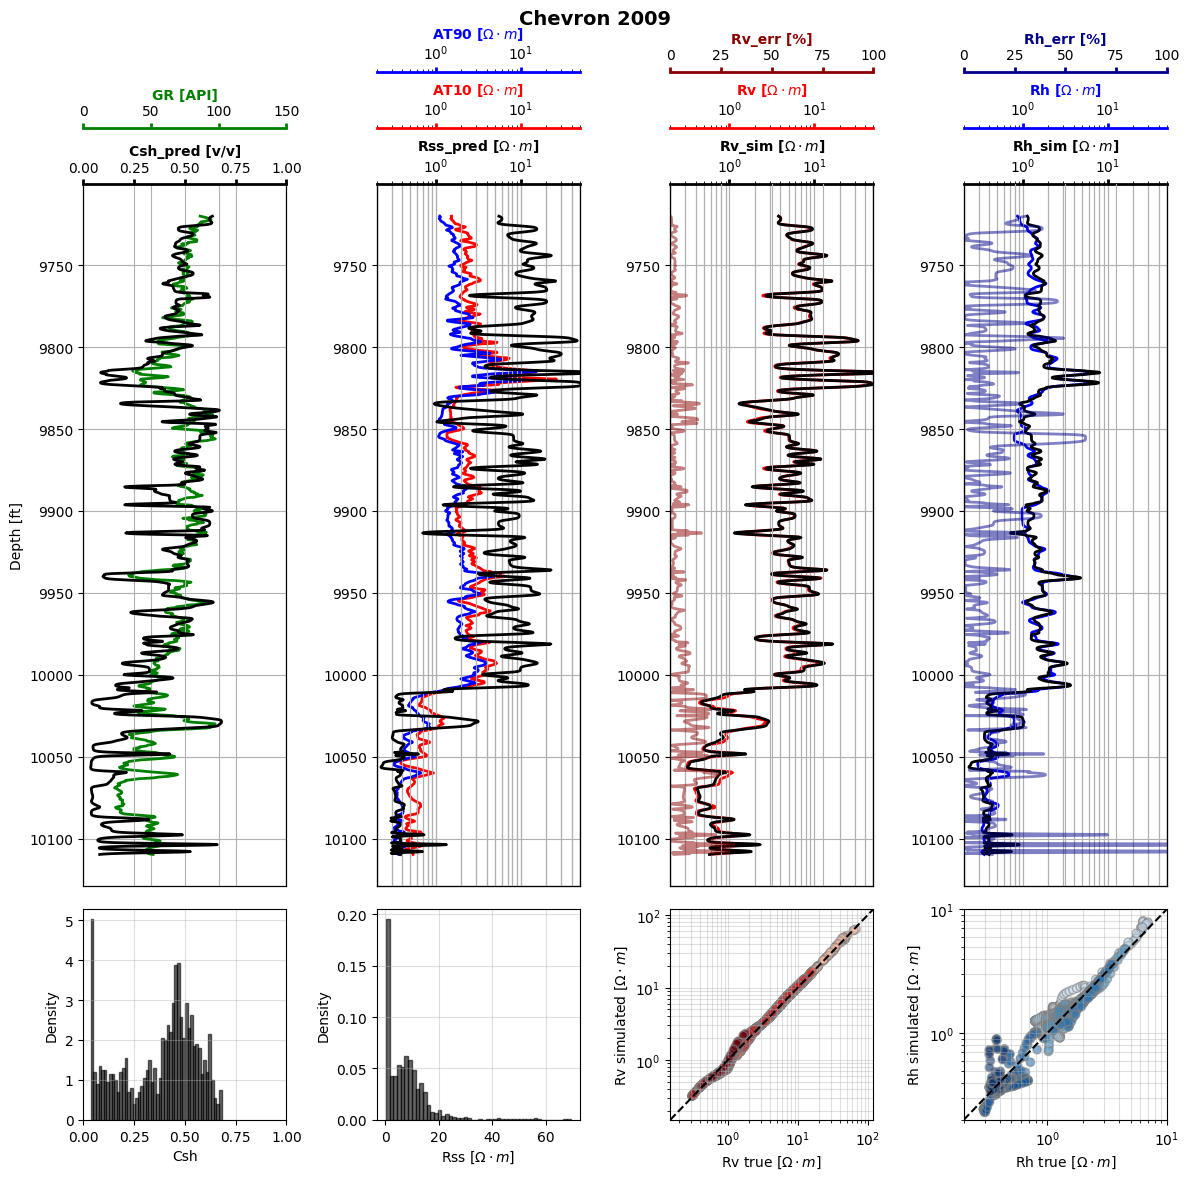

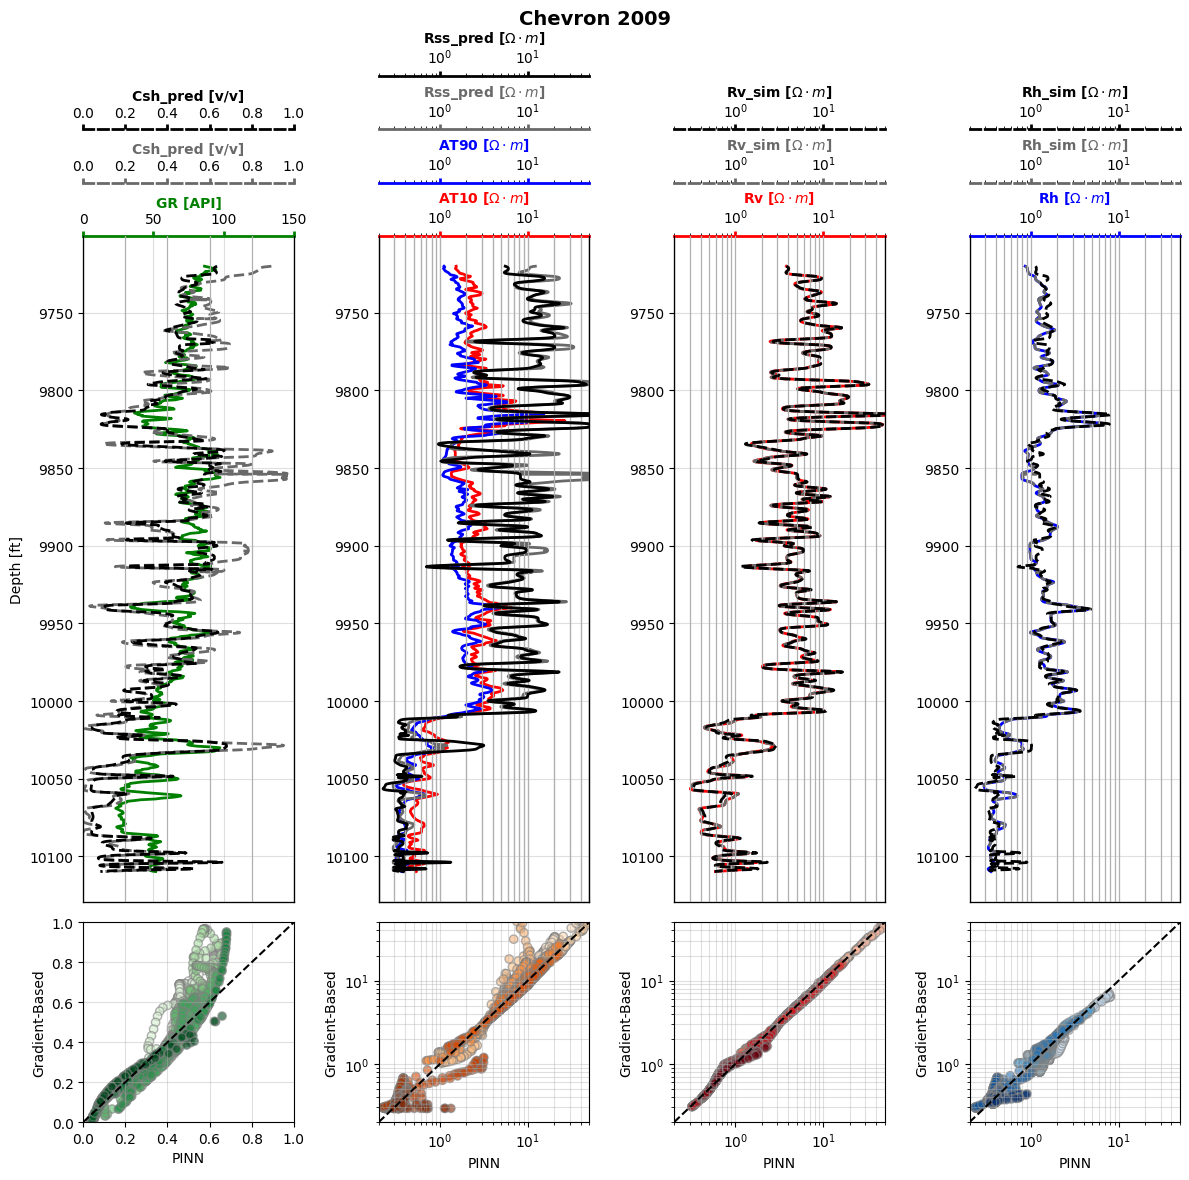

In [10]:
dd = 'AT90'
res_aniso = data1[['Rv', 'Rh', dd, 'Rvsh', 'Rhsh', 'WIDX']]
inputs    = torch.tensor(res_aniso.values, dtype=torch.float32).to(device)
print('Inputs: {}'.format(inputs.shape))

dataset        = TensorDataset(inputs)
train_percent  = 0.85
xtrain, xtest  = random_split(dataset, [int(train_percent*len(dataset)), len(dataset)-int(train_percent*len(dataset))])
xtrain, xvalid = random_split(xtrain, [int(train_percent*len(xtrain)), len(xtrain)-int(train_percent*len(xtrain))])
print('X_train: {} | X_valid: {} | X_test: {}'.format(len(xtrain), len(xvalid), len(xtest)))

batch_size  = 32
trainloader = DataLoader(xtrain, batch_size=batch_size, shuffle=True)
validloader = DataLoader(xvalid, batch_size=batch_size, shuffle=True)

model     = ResInvPINN(hidden_dim=150, csh_constraint_mult=1.75).to(device)
criterion = ResInvLoss(ddmax=data1[dd].max(), lambda_reg=1e-10).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
print('# of Parameters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

epochs, monitor = 501, 100
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    model.train()
    for i, x in enumerate(trainloader):
        optimizer.zero_grad()
        y = model(x[0])
        loss = criterion(x[0], y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for x in validloader:
            y = model(x[0])
            loss = criterion(x[0], y)
            epoch_valid_loss.append(loss.item())
        valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))
losses = (train_loss, valid_loss)
plot_loss(losses)

y_pred = model(inputs[:,:2]).cpu().detach().numpy().squeeze()
Csh_pred, Rss_pred = [y_pred[:, i] for i in range(y_pred.shape[1])]
print('Csh: min={:.3f} | max={:.3f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_true = res_aniso['Rv'].values
Rh_true = res_aniso['Rh'].values
Rvsh    = res_aniso['Rvsh'].values
Rhsh    = res_aniso['Rhsh'].values

Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)

Rv_err = np.abs((Rv_sim - Rv_true)/Rv_true) * 100
Rh_err = np.abs((Rh_sim - Rh_true)/Rh_true) * 100

pinn_sol = pd.DataFrame({'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred, 
                         'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                         'Rv_err':Rv_err, 'Rh_err':Rh_err}, 
                         index=res_aniso.index)

results = pd.concat([data1, pinn_sol], axis=1)
results.to_csv('results/pinn_solution_Chevron.csv', index=True)
error_metrics(results)

s = 'Chevron 2009'
plot_pinn_results(results, suptitle=s)
gradientbased_results = pd.read_csv('results/gradient_based_solution_Chevron.csv', index_col=0)
plot_pinn_gb_comparison(results, gradientbased_results, suptitle=s)

In [6]:
q = np.abs(quadratic_inversion(data1))
q.head()

,Rss_q,Csh_q
DEPTH,,
9720.00,4.559357,0.140053
9720.25,4.621137,0.138185
9720.50,4.677001,0.136683
9720.75,4.719534,0.135620
9721.00,4.746600,0.134965


In [27]:
def quadratic_objective(variables, *args):
    Csh, Rss = variables
    Rv, Rh, Rvsh, Rhsh = args[0], args[1], args[2], args[3]
    eq1 = (Csh*Rvsh + (1-Csh)*Rss) - Rv
    eq2 = (Csh/Rhsh + (1-Csh)/Rss) - (1/Rh)
    return [eq1, eq2]

qinv_results = []
for i, row in data1.iterrows():
    Rv, Rh, Rvsh, Rhsh = row['Rv'], row['Rh'], row['Rvsh'], row['Rhsh']
    result = optimize.newton(func    = quadratic_objective, 
                             x0      = [0.5, 1],
                             args    = (Rv, Rh, Rvsh, Rhsh),
                             maxiter = 1000, 
                             tol     = 1e-6, 
                             disp    = False)
    
result
    #qinv_results.append(result.x)
#qinv_results = pd.DataFrame(qinv_results, columns=['Csh_q', 'Rss_q'], index=data1.index)

/tmp/ipykernel_42752/1377056932.py:4: RuntimeWarning: overflow encountered in scalar multiply
  eq1 = (Csh*Rvsh + (1-Csh)*Rss) - Rv
/tmp/ipykernel_42752/1377056932.py:4: RuntimeWarning: invalid value encountered in scalar add
  eq1 = (Csh*Rvsh + (1-Csh)*Rss) - Rv
/tmp/ipykernel_42752/1377056932.py:5: RuntimeWarning: invalid value encountered in scalar divide
  eq2 = (Csh/Rhsh + (1-Csh)/Rss) - (1/Rh)
/tmp/ipykernel_42752/1377056932.py:11: RuntimeWarning: RMS of 5.0983e+14 reached
  result = optimize.newton(func    = quadratic_objective,
/tmp/ipykernel_42752/1377056932.py:11: RuntimeWarning: RMS of inf reached
  result = optimize.newton(func    = quadratic_objective,
/tmp/ipykernel_42752/1377056932.py:5: RuntimeWarning: invalid value encountered in scalar add
  eq2 = (Csh/Rhsh + (1-Csh)/Rss) - (1/Rh)
/home/misaelmorales/miniconda3/envs/torchy/lib/python3.11/site-packages/scipy/optimize/_zeros_py.py:449: RuntimeWarning: overflow encountered in subtract
  dp = (q1 * (p1 - p))[nz_der] / (q1

array([nan, nan])

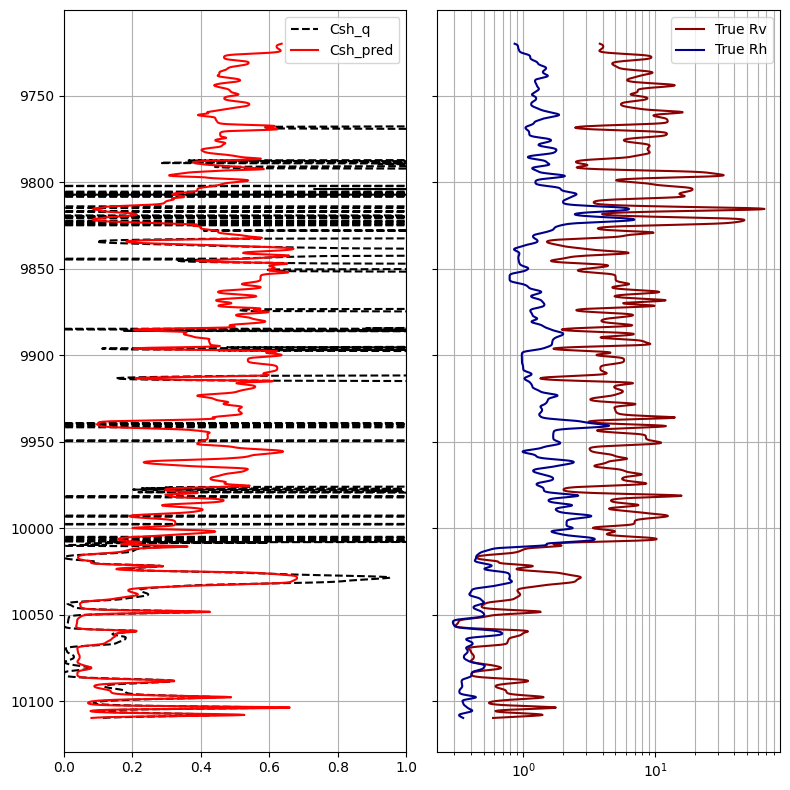

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8,8), sharey=True)
ax1, ax2 = axs

ax1.plot(qinv_results['Csh_q'], qinv_results.index, c='k', ls='--', label='Csh_q')
ax1.plot(results['Csh_pred'], results.index, c='r', ls='-', label='Csh_pred')
ax1.set(xlim=(0,1))

ax2.plot(data1['Rv'], data1.index, c='darkred', label='True Rv')
ax2.plot(data1['Rh'], data1.index, c='darkblue', label='True Rh')
ax2.set(xscale='log')

[ax.grid(True, which='both') for ax in axs]
[ax.legend() for ax in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
s = 'AkerBP Hanz Prospect'
plot_pinn_results(results[data_all['WIDX']==2], suptitle=s)
gradientbased_results = pd.read_csv('results/gradient_based_solution_AkerBP.csv', index_col=0)
plot_pinn_gb_comparison(results[data_all['WIDX']==2], gradientbased_results, suptitle=s)

In [ ]:
s = 'Synthetic Case 1 (Laminated)'
plot_pinn_results(results[data_all['WIDX']==3], figsize=(12,12), suptitle=s)
gradientbased_results = pd.read_csv('results/gradient_based_solution_synthetic1.csv', index_col=0).iloc[22:]
plot_pinn_gb_comparison(results[data_all['WIDX']==3], gradientbased_results, suptitle=s)

In [ ]:
s = 'Synthetic Case 2 (Laminated + Dispersed)'
plot_pinn_results(results[data_all['WIDX']==4], suptitle=s)
gradientbased_results = pd.read_csv('results/gradient_based_solution_synthetic2.csv', index_col=0)
plot_pinn_gb_comparison(results[data_all['WIDX']==4], gradientbased_results, suptitle=s)

***
## Uncertainty Quantification

In [ ]:
r1 = results[data_all['WIDX']==1]
r2 = results[data_all['WIDX']==2]
synthetic_all = pd.concat([r1, r2], ignore_index=False)
s_split = len(r1)
print('Synthetic 1: {} | Synthetic 2: {}'.format(r1.shape, r2.shape))
print('Synthetic All: {}'.format(synthetic_all.shape))

n_realizations = 1000
y_preds = np.zeros((n_realizations, synthetic_all.shape[0], 2))
for i in range(n_realizations):
    
    noisy_inputs = inputs + torch.randn_like(inputs)*0.1
    y_preds[i] = model(noisy_inputs).cpu().detach().numpy().squeeze()
print(y_preds.shape)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10.5,6.5))
ax1, ax2 = axs
titles = ['Chevron2009', 'AkerBP', 'Synthetic 1', 'Synthetic 2']

for i in range(50):
    Csh_pred, Rss_pred = y_preds[i, :, 0], y_preds[i, :, 1]
    Rvsh, Rhsh = results['Rvsh'].values, results['Rhsh'].values
    Rvsim = Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred
    Rhsim = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
    ax1.plot(Rvsim[data_all['WIDX']==1], r1.index, c='rosybrown', alpha=0.1)
    ax1.plot(Rhsim[data_all['WIDX']==1], r1.index, c='lightsteelblue', alpha=0.1)
    ax2.plot(Rvsim[data_all['WIDX']==2], r2.index, c='rosybrown', alpha=0.1)
    ax2.plot(Rhsim[data_all['WIDX']==2], r2.index, c='lightsteelblue', alpha=0.1)

ax1.plot(r1['Rv'], r1.index, c='k', lw=1, ls='--', label='True Rv')
ax1.plot(r1['Rh'], r1.index, c='k', lw=1, ls='-.', label='True Rh')

ax2.plot(r2['Rv'], r2.index, c='k', lw=0.5, ls='--', label='True Rv')
ax2.plot(r2['Rh'], r2.index, c='k', lw=0.5, ls='-.', label='True Rh')

[ax.set_title(titles[i], weight='bold') for i, ax in enumerate(axs)]
[ax.set(xscale='log', ylabel='Depth [ft]', xlabel='$R_i$ $[\Omega\cdot m]$') for ax in axs]
[ax.grid(True, which='both') for ax in axs]
[ax.legend(loc='lower left') for ax in axs]
ax1.invert_yaxis(); ax2.invert_yaxis()
plt.tight_layout()
plt.show()

***
# END